In [ ]:
#SHAP
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, roc_auc_score, precision_recall_curve, average_precision_score
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import mutual_info_classif
import matplotlib.pyplot as plt
import seaborn as sns
import shap

# 全局绘图风格设置
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 15
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15

# 加载训练数据
train_file = '微生物多样性输入变量_带时滞特征特征选择筛选二分类50shuizhiless0612.xlsx'
data_train = pd.read_excel(train_file)

# 数据准备（标准化）
X_train = data_train.iloc[:, :-1]
y_train = data_train.iloc[:, -1]
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# 划分训练测试数据
X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(X_train_scaled, y_train, test_size=0.2, random_state=42)

# 模型训练
model = KNeighborsClassifier(n_neighbors=7, weights='distance', metric='manhattan')
model.fit(X_train_split, y_train_split)

# 预测和评估
train_preds = model.predict(X_train_split)
test_preds = model.predict(X_test_split)

print('=== 训练集评估 ===')
print(classification_report(y_train_split, train_preds))
print(f'训练集准确率: {accuracy_score(y_train_split, train_preds):.3f}\n')

print('=== 内部测试集评估 ===')
print(classification_report(y_test_split, test_preds))
print(f'内部测试集准确率: {accuracy_score(y_test_split, test_preds):.3f}\n')

# SHAP分析（指定第二类概率）
explainer = shap.KernelExplainer(lambda x: model.predict_proba(x)[:, 1], X_train_split[:100])
shap_values = explainer.shap_values(X_test_split[:100])

# SHAP值表格
shap_df = pd.DataFrame(np.abs(shap_values), columns=data_train.columns[:-1])
shap_mean = shap_df.mean().sort_values(ascending=False)
shap_table = pd.DataFrame({
    'Feature': shap_mean.index,
    'SHAP Importance': shap_mean.values
})

print('=== SHAP重要性值表格 ===')
print(shap_table)

# 绘制SHAP重要性图
plt.figure(figsize=(10, 6))
sns.barplot(x='SHAP Importance', y='Feature', data=shap_table, palette='viridis')
plt.title('SHAP Feature Importance')
plt.xlabel('Mean Absolute SHAP Value')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()


=== 训练 集评估 ===
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        93
           1       1.00      1.00      1.00        90

    accuracy                           1.00       183
   macro avg       1.00      1.00      1.00       183
weighted avg       1.00      1.00      1.00       183

总体准确率 (训练): 1.000

=== 测试 集评估 ===
              precision    recall  f1-score   support

           0       0.82      0.93      0.88        30
           1       0.83      0.62      0.71        16

    accuracy                           0.83        46
   macro avg       0.83      0.78      0.79        46
weighted avg       0.83      0.83      0.82        46

总体准确率 (测试): 0.826



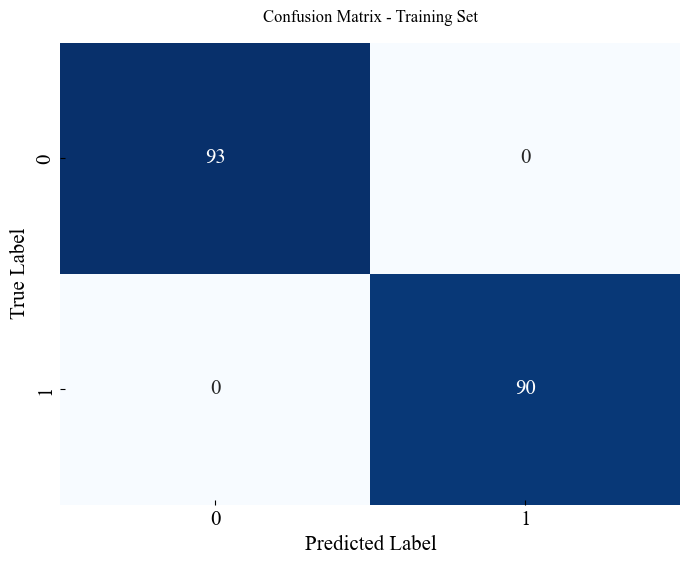

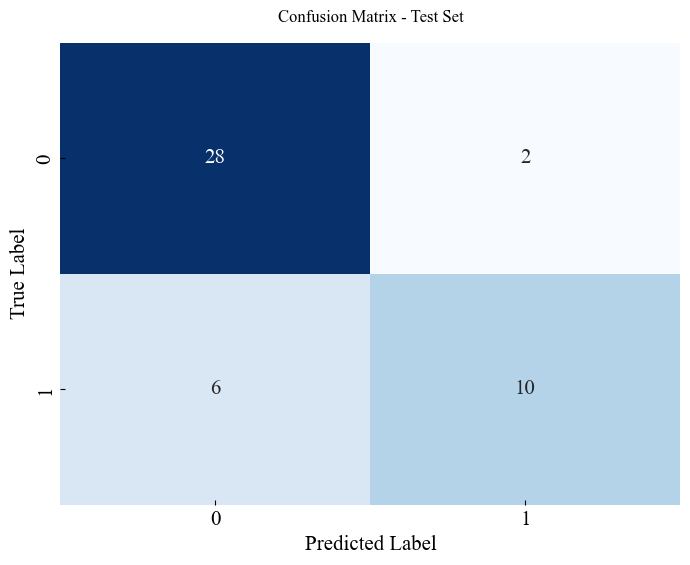

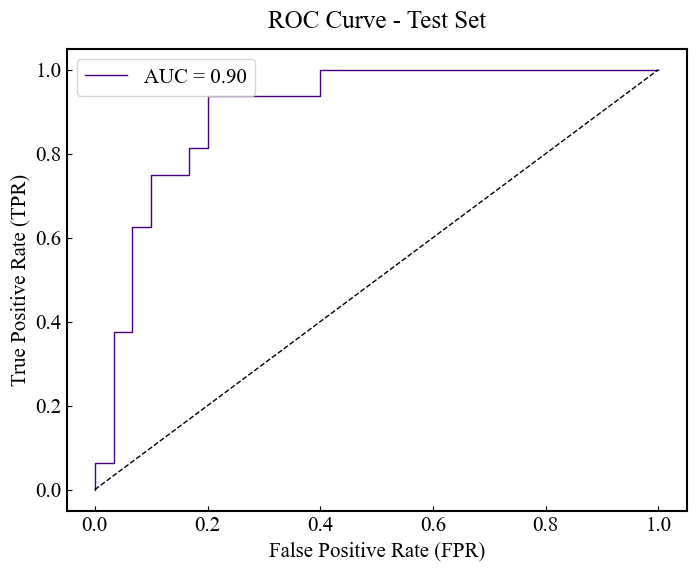

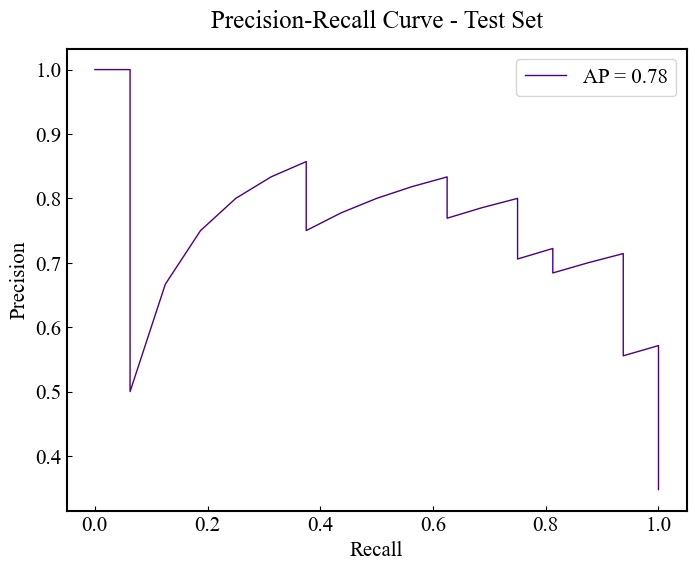

最优阈值: 0.20, F1: 0.789
=== SHAP重要性值表格 ===
                 Feature  SHAP Importance
8  Effluent Ammonia lag1         1.226365
2  Influent Ammonia lag1         0.982038
0                   Time         0.605202
1      Influent COD lag1         0.582841
7           Simpson lag3         0.554129
6           Shannon lag1         0.487649
5          Coverage lag2         0.257712
4               ACE lag3         0.188235
3          Cluster2 lag2         0.160794


C:\Users\Administrator\AppData\Local\Temp\ipykernel_21060\1915618594.py:126: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='SHAP Importance', y='Feature', data=shap_importance_df.head(10), palette='viridis')


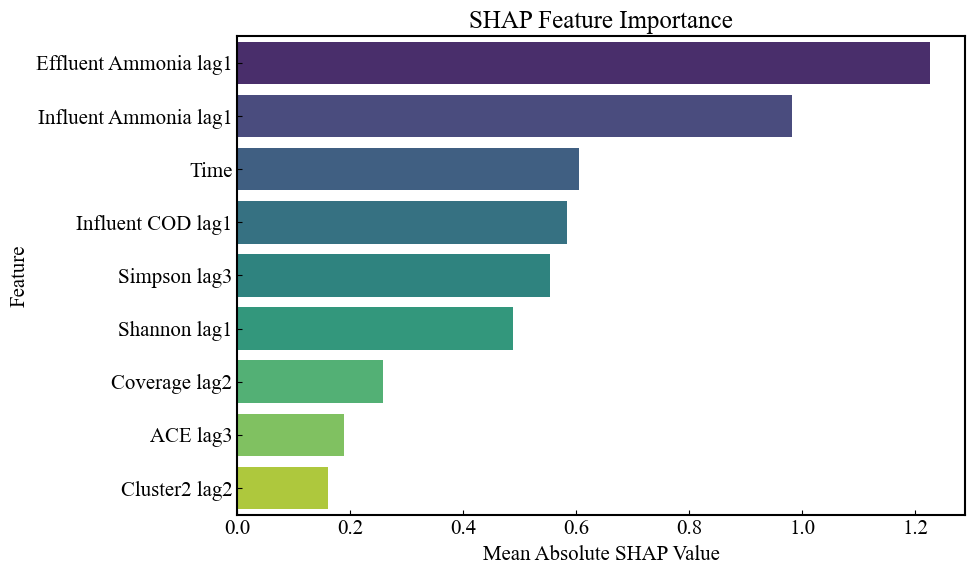

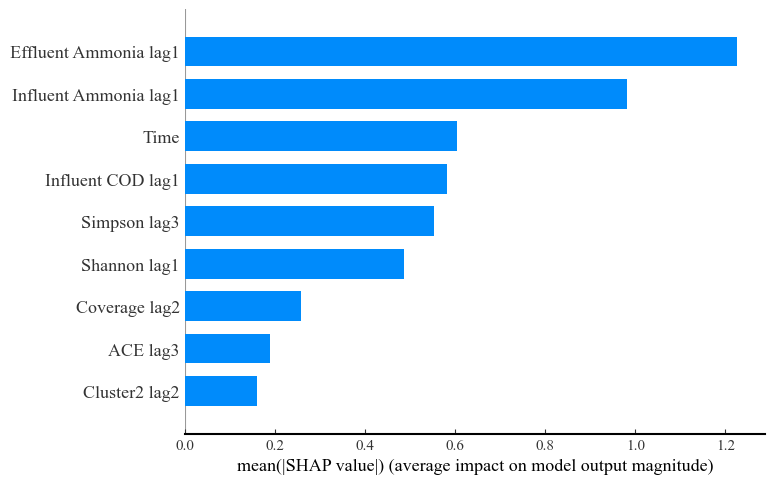

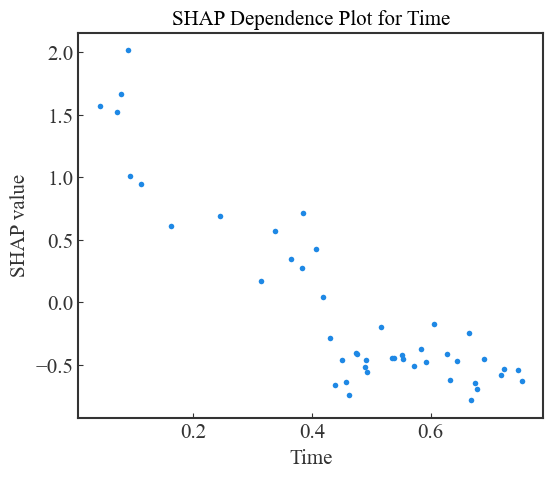

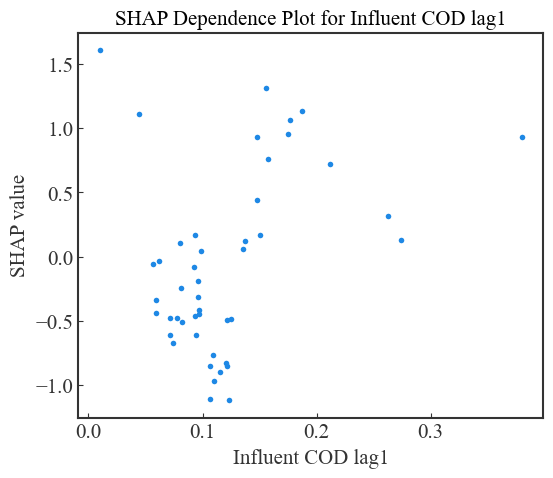

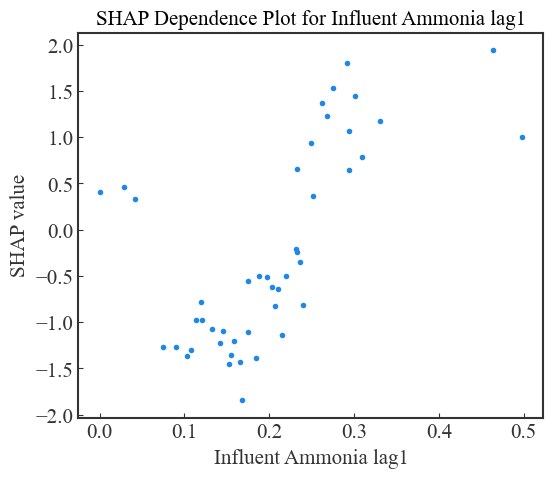

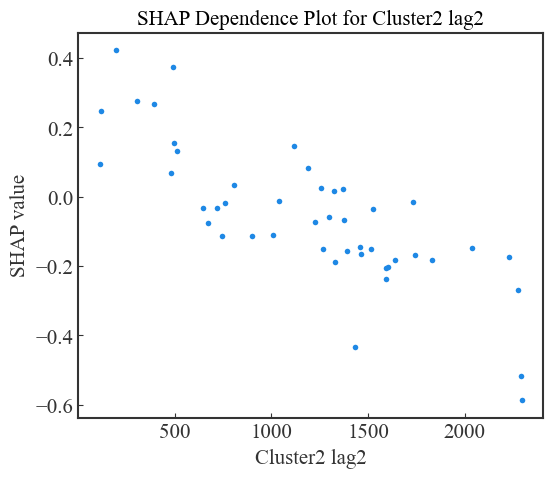

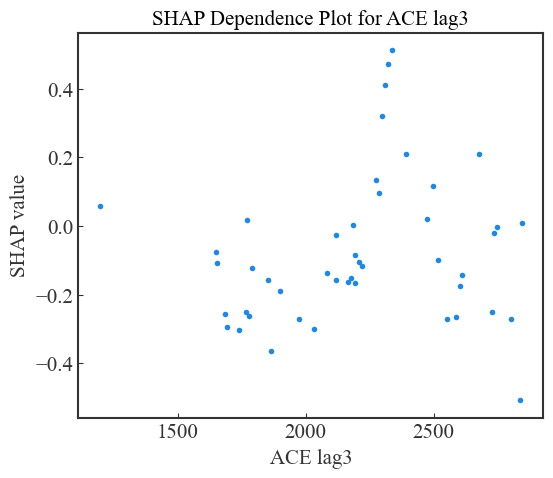

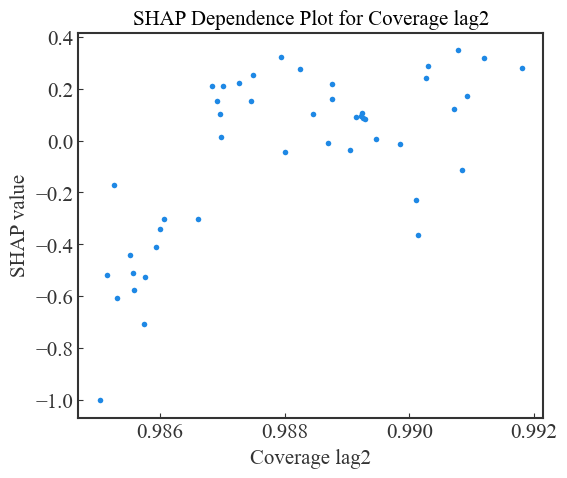

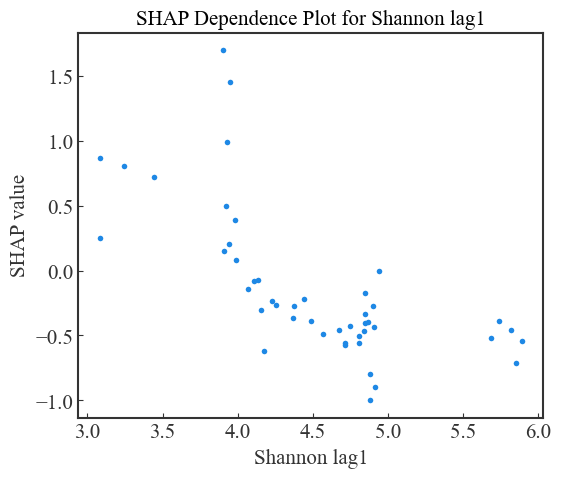

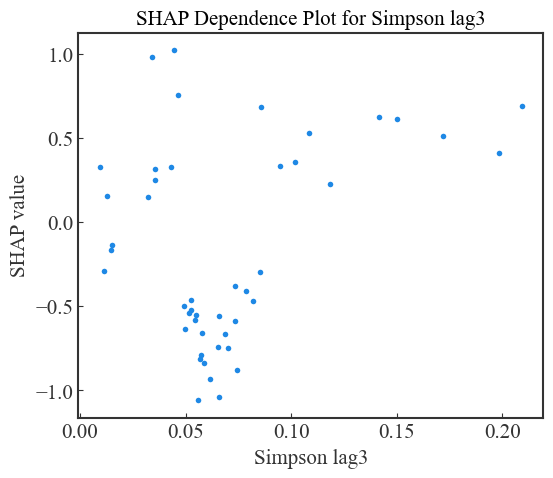

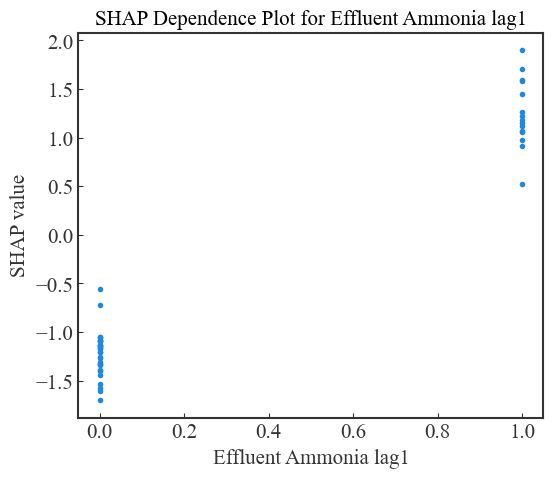

=== 各特征互信息 (MI) 值 ===
              Feature  Mutual Information
                 Time            0.320483
         Simpson lag3            0.192241
         Shannon lag1            0.174803
Effluent Ammonia lag1            0.165144
        Cluster2 lag2            0.150673
        Coverage lag2            0.107268
Influent Ammonia lag1            0.090176
    Influent COD lag1            0.064353
             ACE lag3            0.043024


C:\Users\Administrator\AppData\Local\Temp\ipykernel_21060\1915618594.py:173: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Mutual Information', y='Feature', data=mi_df.head(10), palette='viridis')


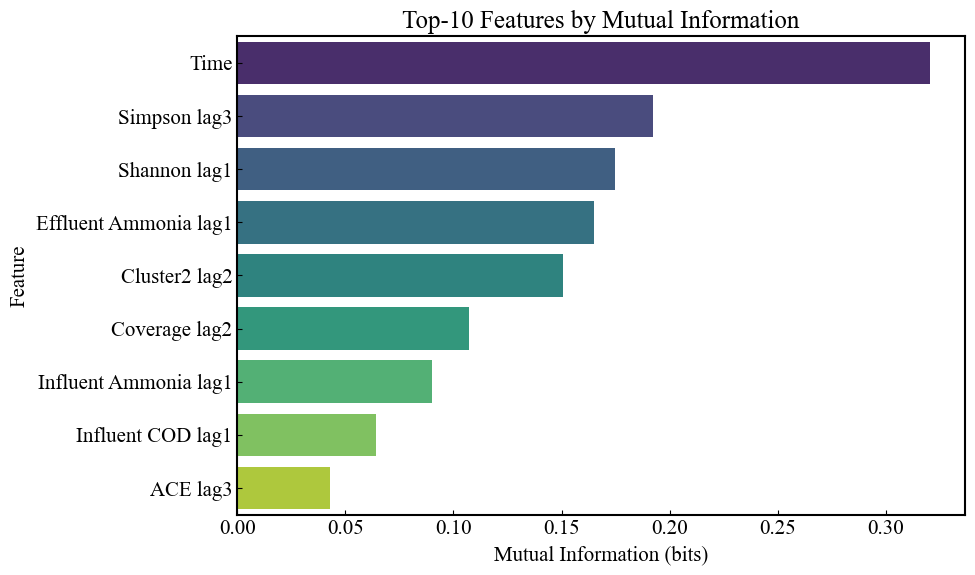

In [3]:
# CatBoost SHAP
import shap 
import pandas as pd
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, roc_auc_score, precision_recall_curve, average_precision_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 设置全局绘图风格，与论文图表一致
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 15
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15

# 1. 加载数据
file_path = '微生物多样性输入变量_带时滞特征特征选择筛选二分类230less0610.xlsx'
data = pd.read_excel(file_path)

# 2. 数据准备
X = data.iloc[:, :-1]
y = data.iloc[:, -1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. 类别权重
neg_count = sum(y_train == 0)
pos_count = sum(y_train == 1)
class_weights = [neg_count / (neg_count + pos_count), pos_count / (neg_count + pos_count)]

# 4. 指定超参数CatBoost模型
model = CatBoostClassifier(
    depth=7,
    learning_rate=0.1,
    iterations=200,
    subsample=0.8,
    l2_leaf_reg=5,
    verbose=False,
    class_weights=class_weights
)
model.fit(X_train, y_train)

# 5. 预测
train_preds = model.predict(X_train)
test_preds = model.predict(X_test)
test_probs = model.predict_proba(X_test)[:, 1]

# 6. 输出指标
def print_metrics(y_true, preds, dataset):
    print(f'=== {dataset} 集评估 ===')
    print(classification_report(y_true, preds))
    print(f'总体准确率 ({dataset}): {accuracy_score(y_true, preds):.3f}\n')

print_metrics(y_train, train_preds, '训练')
print_metrics(y_test, test_preds, '测试')

# 7. 混淆矩阵绘图函数
def plot_cm(y_true, preds, title):
    cm = confusion_matrix(y_true, preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(title, fontsize=12, pad=15)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tick_params(direction='in')
    for spine in plt.gca().spines.values():
        spine.set_linewidth(1.5)
    plt.show()

plot_cm(y_train, train_preds, 'Confusion Matrix - Training Set')
plot_cm(y_test, test_preds, 'Confusion Matrix - Test Set')

# 8. ROC与精确召回曲线
fpr, tpr, _ = roc_curve(y_test, test_probs)
auc_score = roc_auc_score(y_test, test_probs)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='#4B0082', linewidth=1.0, label=f'AUC = {auc_score:.2f}')
plt.plot([0, 1], [0, 1], 'k--', linewidth=1.0)
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve - Test Set', pad=15)
plt.legend()
plt.tick_params(direction='in')
for spine in plt.gca().spines.values():
    spine.set_linewidth(1.5)
plt.show()

precision, recall, _ = precision_recall_curve(y_test, test_probs)
ap_score = average_precision_score(y_test, test_probs)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='#4B0082', linewidth=1.0, label=f'AP = {ap_score:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - Test Set', pad=15)
plt.legend()
plt.tick_params(direction='in')
for spine in plt.gca().spines.values():
    spine.set_linewidth(1.5)
plt.show()

# 9. 阈值分析
thresholds = np.arange(0.1, 1.0, 0.1)
f1_scores = [f1_score(y_test, (test_probs >= thr).astype(int)) for thr in thresholds]
optimal_thr = thresholds[np.argmax(f1_scores)]
print(f'最优阈值: {optimal_thr:.2f}, F1: {max(f1_scores):.3f}')

# 10. 特征重要性和SHAP分析
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

shap_abs_mean = np.abs(shap_values).mean(axis=0)
shap_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'SHAP Importance': shap_abs_mean
}).sort_values(by='SHAP Importance', ascending=False)

print('=== SHAP重要性值表格 ===')
print(shap_importance_df)

plt.figure(figsize=(10, 6))
sns.barplot(x='SHAP Importance', y='Feature', data=shap_importance_df.head(10), palette='viridis')
plt.title('SHAP Feature Importance')
plt.xlabel('Mean Absolute SHAP Value')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

# SHAP摘要图
shap.summary_plot(shap_values, X_test, plot_type="bar", max_display=10)

# SHAP 部分依赖图
# SHAP 部分依赖图（闭合绘图区域）
for feature in X.columns:
    shap.dependence_plot(feature, shap_values, X_test, interaction_index=None, show=False)
    plt.grid(False)  # 去除背景网格线
    plt.gca().spines['top'].set_visible(True)
    plt.gca().spines['right'].set_visible(True)
    plt.gca().spines['bottom'].set_visible(True)
    plt.gca().spines['left'].set_visible(True)
    plt.tick_params(direction='in', labelsize=15)
    plt.xlabel(feature, fontsize=15)
    plt.ylabel("SHAP value", fontsize=15)
    plt.title(f'SHAP Dependence Plot for {feature}', fontsize=15)
    plt.show()

# 11. 互信息 (Mutual Information, MI) 分析
from sklearn.feature_selection import mutual_info_classif

# 计算互信息
mi_scores = mutual_info_classif(
    X,                 # 特征矩阵（全部样本）
    y,                 # 目标变量
    discrete_features='auto',  # 根据 dtype 自动判断离散/连续
    random_state=42
)

# 整理结果
mi_df = pd.DataFrame({
    'Feature': X.columns,
    'Mutual Information': mi_scores
}).sort_values(by='Mutual Information', ascending=False)

print('=== 各特征互信息 (MI) 值 ===')
print(mi_df.to_string(index=False))

# 可视化
plt.figure(figsize=(10, 6))
sns.barplot(x='Mutual Information', y='Feature', data=mi_df.head(10), palette='viridis')
plt.title('Top-10 Features by Mutual Information')
plt.xlabel('Mutual Information (bits)')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()
